In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%load_ext rpy2.ipython

##### Load the data
Remove RT outliers (defined as any response time less than 0.2 seconds). This also eliminates the trials where the subject did not respond.

In [6]:
data = pd.read_csv('../../data/behavioral_data.csv').query('RT > 0.2')

In [11]:
print("High reward mean acceptance rate:", data.query("condition == 'equalIndifference'")["accept"].mean())
print("Low reward mean acceptance rate:", data.query("condition == 'equalRange'")["accept"].mean())
print("High reward mean RT:", data.query("condition == 'equalIndifference'")["RT"].mean())
print("Low reward mean RT:", data.query("condition == 'equalRange'")["RT"].mean())


High reward mean acceptance rate: 0.688623595505618
Low reward mean acceptance rate: 0.46961910519951633
High reward mean RT: 1.6830212078651683
Low reward mean RT: 1.5445359733978237


### Analysis of acceptance rate
**Question: How does gain and loss affect acceptance rate? Does it change based on the condition?**

Model 1: Predict acceptance rate as a function of condition, gain and loss

In [7]:
%%R -i data
library(lme4)
library(lmerTest)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [23]:
%%R
model1 <- glmer(accept ~ condition*gain + condition*loss + (1|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accept ~ condition * gain + condition * loss + (1 | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  6733.3   6786.0  -3359.6   6719.3    13729 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-260.486   -0.154    0.022    0.201  216.884 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 4.503    2.122   
Number of obs: 13736, groups:  sub, 54

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.248046   0.430556   0.576   0.5645    
conditionequalRange      -1.036262   0.618566  -1.675   0.0939 .  
gain                      0.321002   0.008887  36.121   <2e-16 ***
loss                     -0.476398   0.014630 -32.563   <2e-16 ***
conditionequalRange:gain  0.386159   0.022132  17.448   <2e-16 ***
conditionequalRange:loss -0.206953   0.024

In [25]:
%%R
# Model comparison 
model2 <- glmer(accept ~ condition + gain + loss + (1|sub), data=data, family=binomial)
anova(model1, model2)

Data: data
Models:
model2: accept ~ condition + gain + loss + (1 | sub)
model1: accept ~ condition * gain + condition * loss + (1 | sub)
       npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model2    5 7193.0 7230.6 -3591.5   7183.0                         
model1    7 6733.3 6786.0 -3359.6   6719.3 463.69  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Findings:**
1. No significant effect of condition on acceptance rate
2. For the high reward condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.321
3. For the low reward condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.707
4. For the high reward condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.476
5. For the low reward condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.683

For high reward, the ratio for loss/gain is 0.476/0.321 = 1.483 (loss averse behavior). For low reward, the ratio for loss/gain is 0.683/0.707 = 0.966 (not loss averse).

After model comparison, we find that gain and loss interact with the condition. 

### Analysis of response time
**Question: What are the differences in response time between conditions? Are acceptances faster than rejections between conditions?**

Model 2: Predict response time as a function of condition, gain, loss, distance from indifference and response.


In [14]:
%%R
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model3 <- lmer(RT ~ gain*condition + loss*condition + dist_from_indiff*condition + accept*condition + (1|sub), data=data)
summary(model3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain * condition + loss * condition + dist_from_indiff *  
    condition + accept * condition + (1 | sub)
   Data: data

REML criterion at convergence: 19654.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6201 -0.6669 -0.1559  0.5075  5.2706 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09795  0.313   
 Residual             0.23909  0.489   
Number of obs: 13736, groups:  sub, 54

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           1.619e+00  6.430e-02  7.123e+01  25.179
gain                                  2.143e-02  2.071e-03  1.368e+04  10.347
conditionequalRange                  -5.668e-02  9.275e-02  7.148e+01  -0.611
loss                                 -4.406e-03  2.259e-03  1.368e+04  -1.950
dist_from_indiff                     -5.067e-02  3.095e-

In [29]:
%%R
# Post-hoc tests for condition equalRange (low reward)
model4 <- lmer(RT ~ gain + loss + dist_from_indiff + accept + (1|sub), data=data[data$condition == 'equalRange', ])
summary(model4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + accept + (1 | sub)
   Data: data[data$condition == "equalRange", ]

REML criterion at convergence: 8758.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7343 -0.6641 -0.1618  0.5125  5.5621 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09784  0.3128  
 Residual             0.21469  0.4633  
Number of obs: 6616, groups:  sub, 26

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.562e+00  6.627e-02  3.346e+01  23.576  < 2e-16 ***
gain             -5.511e-05  1.572e-03  6.596e+03  -0.035    0.972    
loss              8.651e-03  1.547e-03  6.595e+03   5.594 2.31e-08 ***
dist_from_indiff -3.172e-02  2.133e-03  6.586e+03 -14.873  < 2e-16 ***
accept           -1.011e-02  1.781e-02  6.606e+03  -0.568    0.570    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.0

In [30]:
%%R
# Post-hoc tests for condition equalIndifference (high reward)
model5 <- lmer(RT ~ gain + loss + dist_from_indiff + accept + (1|sub), data=data[data$condition == 'equalIndifference', ])
summary(model5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + accept + (1 | sub)
   Data: data[data$condition == "equalIndifference", ]

REML criterion at convergence: 10829.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5035 -0.6722 -0.1519  0.5033  4.9836 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09806  0.3131  
 Residual             0.26177  0.5116  
Number of obs: 7120, groups:  sub, 28

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.619e+00  6.480e-02  3.799e+01  24.987  < 2e-16 ***
gain              2.143e-02  2.167e-03  7.092e+03   9.890  < 2e-16 ***
loss             -4.410e-03  2.364e-03  7.093e+03  -1.865   0.0622 .  
dist_from_indiff -5.068e-02  3.239e-03  7.089e+03 -15.647  < 2e-16 ***
accept            9.801e-02  1.898e-02  7.112e+03   5.163  2.5e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 

**Findings:**
1. Condition has no significant effect on response time.
2. In high reward condition, there is a significant effect of gain on response time.
    * Beta of 0.021
3. In low reward condition, there is a significant effect of gain on response time.
    * Beta of ~0
    * This is not significant after post-hoc analysis. 
4. In high reward condition, there is not a significant effect of loss on response time.
5. In low reward condition, there is a significant effect of loss on response time.
    * Beta of 0.009
6. In high reward condition, there is a significant effect of distance from indifference on response time.
    * Beta of -0.05
7. In low reward condition, there is not a significant effect of distance from indifference on response time.
    * Beta of -0.03
8. In high reward condition, there is a significant effect of accepting on response time.
    * Beta of 0.098
9. In low reward condition, there is a significant effect of accepting on response time.
    * Beta of -0.01
    * This is not significant after post-hoc analysis. 

For the high reward condition, increasing gains make people respond faster, while increasing losses has no effect. In the low reward condition, this effect is reversed: increasing gains causes no effect on response time, while increasing losses makes people respond faster.

For both conditions, the distance from indifference makes response times faster (the high reward condition is a little more pronounced). 

Finally, accept trials are slower than reject trials in the high reward condition, but not in the low reward condition. This effect is not due to the gains, losses or distance from indifference seen in the trials. 

### Visualization of response times: 

**TODO**: We might need to adjust the distance from indifference for the high reward condition, since this might be different from the low reward condition. Notice in the plot below, rejections look slower than acceptances, but the opposite is true in our model. 


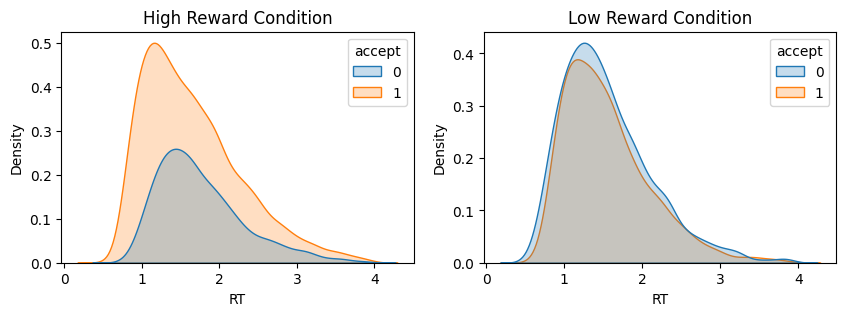

In [42]:
# For each condition, do a histogram of RT based on accept
# Figure with two subplots, one for each condition
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(data=data.query('condition == "equalIndifference"'), fill = True, x='RT', hue='accept', ax=axs[0])
sns.kdeplot(data=data.query('condition == "equalRange"'), fill = True, x='RT', hue='accept', ax=axs[1]) 
axs[0].set_title('High Reward Condition')
axs[1].set_title('Low Reward Condition')
plt.show()


### Visualization of acceptance rate

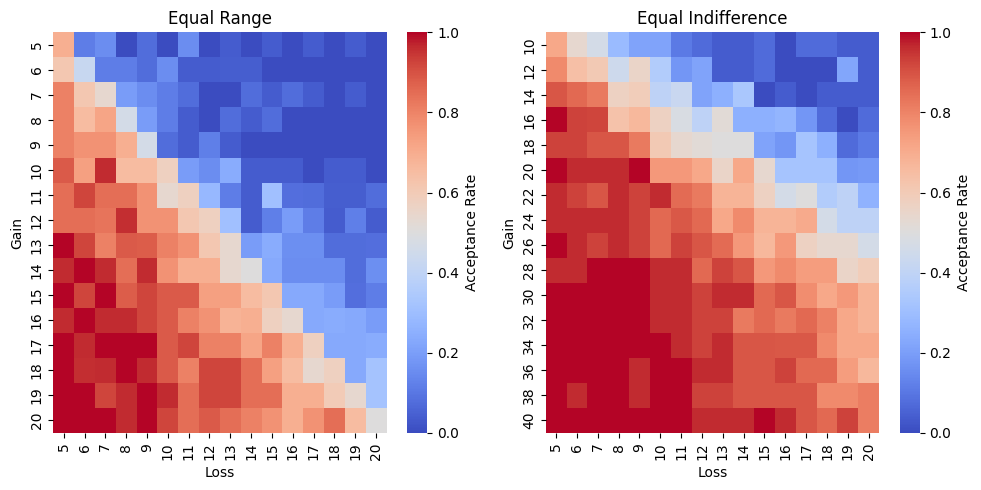

In [17]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()